# Case6-Challenge00b

In this notebook, we estimate the field parameters and sky coordinates of objects from the observed positions on the focal plane and pointing information. The uncertainty on the pointing position is omitted in this note.

## Preparation

## Environment setting.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

### Loading data.

In [2]:
import astropy.io.ascii as asc
import astropy.units as u

objects = asc.read('case6_challenge_00.txt') #consists of x (um), y (um), catalog_id, ra (deg), dec (deg), and field.
pointings = asc.read('case6_challenge_00_pointing.txt') # consists of field, ra (deg), dec (deg), and pa (deg).

### Reducing data.

In [3]:
import numpy as np

pos = np.where(objects['field']<=10)
objects = objects[pos]

pos = np.where((objects['catalog_id']%10==0))
objects = objects[pos]

pos = np.where(pointings['field']<=10)
pointings = pointings[pos]

### Modifying catalog ids.

In [4]:
from astropy.table import unique

ids = unique(objects, keys='catalog_id')['catalog_id']
objects.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(objects['catalog_id']==ids[i])
    objects['id'][pos] = i

objects.remove_column('catalog_id')
objects.rename_column('id', 'catalog_id')

### Preparing some arrays.

From the data, we prepare two arrays. One contains true sky coodinates and catalog_id (true_radec). The other one contains observed field-id, focal-plane position (um) and catalog id (observed_xy).

In [5]:
from astropy.table import unique

true_radec = objects['catalog_id', 'ra', 'dec'].copy()
true_radec.sort('catalog_id')
true_radec = unique(true_radec, keys='catalog_id') # consists of catalog_id, ra (deg), and dec (deg).

observed_xy = objects['field', 'x', 'y', 'catalog_id', 'ra', 'dec'].copy()
observed_xy.rename_column('ra', 'ra_est')
observed_xy.rename_column('dec', 'dec_est')
# observed_xy will have field, x (um), y (um), catalog_id, and estimated ra/dec (deg).

# initializing ra_est and dec_est
observed_xy['ra_est']  = 0.0
observed_xy['dec_est'] = 0.0

We make another array which contains field parameters.These parameters will be used as the first approximation of the field parameters. At this time, the uncertainties are omitted, but pa and scale are approximated values.

In [6]:
import numpy as np

field_params = pointings.copy()
#field_params['ra'] += np.random.normal(0.0, 0.01, size=np.size(field_params))
#field_params['dec']+= np.random.normal(0.0, 0.01, size=np.size(field_params))
#field_params['pa'] += np.random.normal(0.0, 0.01, size=np.size(field_params))
field_params['pa'] += 55.0 # offset between gal. coord and icrs coord.
field_params.add_column(8e-06*u.deg/u.mm, name='scale')
# field_params will have field, ra (deg), dec (deg), pa (deg), and scale.

## Object distribution

Let's check the object distribution.

Text(0, 0.5, 'dec (deg)')

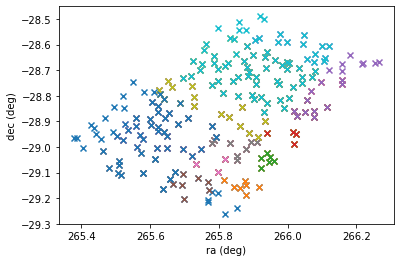

In [8]:
import matplotlib.pylab as plt
import numpy as np

for i in range(0, np.max(field_params['field'])+1):
    pos = np.where(objects['field']==i)
    plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='x')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

## Estimation of sky coordinates

Here, we define a function to construct a wcs instance from given field parameters.

In [9]:
from astropy.wcs import WCS
from astropy.wcs import Sip
import astropy.units as u

def wcs(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa_ptg*u.deg), np.sin(pa_ptg*u.deg)],
              [-np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
    if a is not None and b is not None:
        w.sip = Sip(a, b, ap, bp, [0, 0])
    return w

Then, we estimate the sky coordinates from the observed focal-plane positions and (approximated) field parameters.

In [10]:
for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], fp['scale'])
    pos = np.where(observed_xy['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy[pos]['x']], [observed_xy[pos]['y']])).T, 0)
    observed_xy['ra_est'][pos]  = ret[:, 0]
    observed_xy['dec_est'][pos] = ret[:, 1]

Let's check the true positions and estimated positions.

Text(0, 0.5, 'dec (deg)')

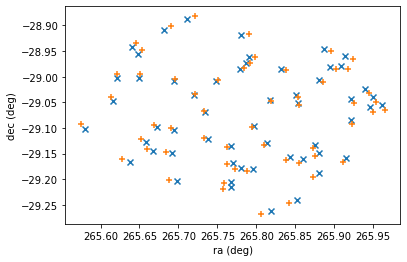

In [11]:
pos = np.where(objects['field']==0)
plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='x', label='True')
pos = np.where(observed_xy['field']==0)
plt.scatter(observed_xy['ra_est'][pos], observed_xy['dec_est'][pos], marker='+', label='Estimated')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

Finally, we estimate the sky coodinates by averaging the values in each frame.

In [12]:
from astropy.table import QTable

radec_est = QTable(names=['catalog_id', 'ra_est', 'dec_est'],\
           units=[None, u.deg, u.deg],\
           dtype=['int64', 'float64', 'float64'])

cat_ids = unique(observed_xy, 'catalog_id')['catalog_id']

for i in cat_ids:
    pos = np.where(observed_xy['catalog_id'] == i)
    ra = np.mean(observed_xy[pos]['ra_est'])*u.deg
    dec = np.mean(observed_xy[pos]['dec_est'])*u.deg
    radec_est.add_row([i, ra, dec])

## Parameter adjustment

At first, we define a function which calculates x/y positions from the ra/dec values estimated above and the field/catalog ids.

In [13]:
def xy_calculator(observed_xy, field_params, radec_info):
    # observed_xy:  consists of field, x (um), y (um), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    observed_xy_cp = observed_xy.copy()
    observed_xy_cp.rename_column('x', 'x_est')
    observed_xy_cp.rename_column('y', 'y_est')
    observed_xy_cp['x_est']   = None
    observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None

    for i in range(0, np.size(radec_info)):
        pos = np.where(observed_xy_cp['catalog_id']==radec_info[i]['catalog_id'])
        observed_xy_cp['ra_est'][pos]  = radec_info[i]['ra_est']
        observed_xy_cp['dec_est'][pos] = radec_info[i]['dec_est']
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], fp['scale'])
        pos = np.where(observed_xy_cp['field']==fp['field'])
        ret = w.all_world2pix(np.concatenate(([observed_xy_cp[pos]['ra_est']], [observed_xy_cp[pos]['dec_est']])).T, 0)
        observed_xy_cp['x_est'][pos] = ret[:, 0]
        observed_xy_cp['y_est'][pos] = ret[:, 1]

    return observed_xy_cp['x_est', 'y_est']

In [14]:
from astropy.table import Table

def model(params, n_fields, n_objects, observed_xy):
    # params = (ra_ptg...dec_ptg...pa_ptg...scale...ra_obj...dec_obj)
    ra_ptgs, dec_ptgs, pa_ptgs, scales, ra_objs, dec_objs =\
        np.split(params, [n_fields, n_fields*2, n_fields*3, n_fields*4, n_fields*4+n_objects])
    a = QTable(names=['catalog_id', 'ra_est', 'dec_est'],\
           units=[None, u.deg, u.deg],\
           dtype=['int64', 'float64', 'float64'])
    
    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, scales, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'scale', 'field'],\
                         units=[u.deg, u.deg, u.deg, u.deg/u.um, None],\
                         dtype=['float64', 'float64', 'float64', 'float64', 'int64'])
    
    radec_info = Table(data=[ra_objs, dec_objs, -np.ones(shape=(np.size(ra_objs)))],\
                       names=['ra_est', 'dec_est', 'catalog_id'],\
                       units=[u.deg, u.deg, None],\
                       dtype=['float64', 'float64', 'int64'])

    field_params['field'] = np.arange(0, np.size(field_params))
    radec_info['catalog_id'] = np.arange(0, np.size(radec_info))

    ret = xy_calculator(observed_xy, field_params, radec_info)

    return np.concatenate((ra_ptgs, dec_ptgs, ret['x_est'], ret['y_est']))

In [15]:
from common.leastsquare import LeastSquare

ls = LeastSquare(lambda a: model(a, np.size(field_params), np.size(radec_est), observed_xy),\
                 np.size(field_params)*2+np.size(observed_xy)*2)

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], field_params['pa'], field_params['scale'],\
                                  radec_est['ra_est'], radec_est['dec_est']))) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
measured = np.concatenate((field_params['ra'], field_params['dec'], observed_xy['x'], observed_xy['y']))
#pos = np.where(measured>180.)
#measured[pos] -= 360.
#pos = np.where(measured<-180.)
#measured[pos] += 360.

result, _ = ls.solve(measured, a_init, max_iteration=30)

## pa should be a positive value between 0 and 360.
#if result[3] < 0:
#    result[3] = -result[3]
#    result[2] = result[2] + 180.0
#
#if result[2] > 360.0 or result[2] < 0.0:
#    result[2] = result[2]%360.0

2021-07-18 09:00:37,705  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 12.215803)
2021-07-18 09:00:54,721  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 1.194065)
2021-07-18 09:01:11,624  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.038987)
2021-07-18 09:01:28,878  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.000652)
2021-07-18 09:01:45,325  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.000016)
2021-07-18 09:02:01,816  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-07-18 09:02:18,716  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-07-18 09:02:35,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-07

In [16]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
ra_ptgs, dec_ptgs, pa_ptgs, scales, ra_objs, dec_objs = np.split(result,\
                                                                 [n_fields, n_fields*2, n_fields*3, n_fields*4, n_fields*4+n_objects])

Text(0.5, 1.0, 'Telescope pointings')

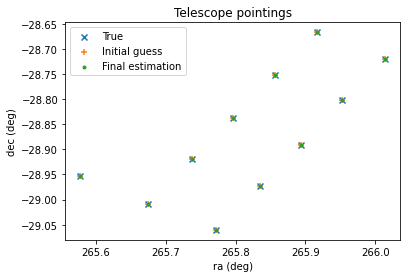

In [17]:
plt.scatter(pointings['ra'], pointings['dec'], marker='x', label='True')
plt.scatter(a_init[0:11], a_init[11:22], marker='+', label='Initial guess')
plt.scatter(result[0:11], result[11:22], marker='.', label='Final estimation')
plt.legend()
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Telescope pointings')

In [18]:
scales

array([7.84873688e-06, 7.84873688e-06, 7.84873688e-06, 7.84873688e-06,
       7.84873688e-06, 7.84873688e-06, 7.84873688e-06, 7.84873688e-06,
       7.84873688e-06, 7.84873688e-06, 7.84873688e-06])

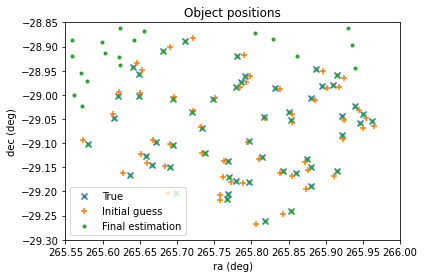

In [19]:
pos = np.where(objects['field']==0)
plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='x', label='True')
pos = np.where(observed_xy['field']==0)
plt.scatter(observed_xy['ra_est'][pos], observed_xy['dec_est'][pos], marker='+', label='Initial guess')
plt.scatter(ra_objs, dec_objs, marker='.', label='Final estimation')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.xlim([265.55, 266.0])
plt.ylim([-29.3, -28.85])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

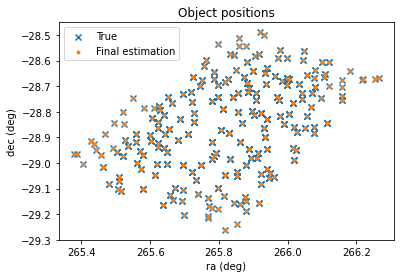

In [21]:
plt.scatter(objects['ra'], objects['dec'], marker='x', label='True')
plt.scatter(ra_objs, dec_objs, marker='.', label='Final estimation')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

In [30]:
from astropy.coordinates import SkyCoord

distlist = []
for i in range(0, np.size(ra_objs)):
    c1 = SkyCoord(ra_objs[i]*u.deg, dec_objs[i]*u.deg)
    c2 = SkyCoord(true_radec['ra'][i]*u.deg, true_radec['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

Text(0, 0.5, 'Number')

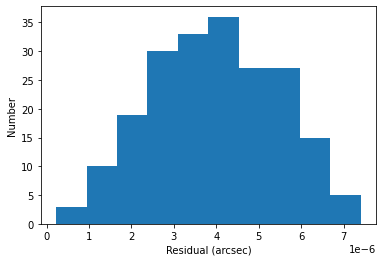

In [33]:
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")